<a href="https://colab.research.google.com/github/j3nguyen/user_item_embeddings/blob/master/NextAction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting User Journeys


Regardless of your business, being able to anticipate your users’ next action is a valuable advantage, whether that be a purchase, a view, or even a cancellation. Typical modelling approaches to predict users’ actions have focused on one specific action, e.g., conversion or churn. In this holistic approach, we model a users’ journey, so that we can not only anticipate a user’s next action but also the one after that.

There are many ways we can frame the problem. Here are four possible neural network architectures to solve the problem:

1.   Multi-class classification
2.   Fixed-length RNN
3. Variable-length RNN
4. Multi-step prediction RNN

Models 1 and 2 use a fixed number of historical actions to predict the next action, whereas Model 3 uses any number of previous actions to predict the next. Model 4 also uses a fixed number of previous actions but instead of predicting the next action, it predicts the next m actions.

All models are trained using the this e-commerce [data set](https://www.kaggle.com/retailrocket/ecommerce-dataset).



In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib
import pickle
import bz2

In [0]:
import keras
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Dense, Average, Dropout, Embedding, Activation, TimeDistributed, Concatenate, Flatten, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%run utils.py

## Data Preparation

Each model will require a different data preparation, but we will start by reading in the data.

In [0]:
df = pd.read_csv("events.csv")

#sort the dataframe by time
df.sort_values(by="timestamp", inplace=True)
df.head()

,timestamp,visitorid,event,itemid,transactionid
1462974,1430622004384,693516,addtocart,297662,NaN
1464806,1430622011289,829044,view,60987,NaN
1463000,1430622013048,652699,view,252860,NaN
1465287,1430622024154,1125936,view,33661,NaN
1462955,1430622026228,693516,view,297662,NaN


In [0]:
# get all the visitor_ids
visitor_ids = df.visitorid.unique()

print("There are {} users".format(len(visitor_ids)))

There are 1407580 users


In [0]:
# inspect action distribution
df.event.value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [0]:
# encode actions to numbers
action_to_idx = {"view": 0, "addtocart": 1, "transaction": 2}

#### User Activity

For models 1, 2 and 4 we want to rearrange the data so each row is one user and his/her sequence of actions.

In [0]:
visitor_activity = pickle.load(bz2.BZ2File('visitor_activity.pkl', 'r'))

In [0]:
# creating dictionary of visitor sequence of activity
visitor_activity = {}

for visitor in visitor_ids:
  # get user's actions in order of time
  actions = df[df.visitorid == visitor].event.values
  
  if len(actions) > 10:
    # get the first 51 actions
    actions = list(map(lambda x: action_to_idx[x],actions)) [:11] 
    visitor_activity[visitor] = actions

#### User sessions

For model 3, each row is a user session, where a new session starts after 30 minutes and each session has at least two actions so that we can use the last action as the target action to predict. This scenario most closely resembles user online activity.

The following code creates a dictionary of sessions for each user.

In [0]:
visitor_sessions = pickle.load(bz2.BZ2File('visitor_sessions.pkl', 'r'))

In [0]:
#30 mins in miliseconds 
session_expire = 60*30*1000

visitor_sessions = {}

for visitor in visitor_ids[:100000]:
    # calculate time deltas between actions
    time_delta = df[df.visitorid == visitor].timestamp.diff()
    actions = df[df.visitorid == visitor].event.values

    if len(actions) > 1:
      # split actions into sessions, where a session ends after session_expire
      all_sessions = np.split(actions,np.where(time_delta >= session_expire)[0])

      # sessions with more than one action
      filtered_sessions = list(filter(lambda x: len(x) > 1, all_sessions))

      if len(filtered_sessions) > 0:
        visitor_sessions[visitor] = list(map(lambda x: list(map(lambda y: action_to_idx[y],x)) ,filtered_sessions))


In [0]:
# pickle.dump( visitor_sessions, bz2.BZ2File('/content/drive/My Drive/Colab Notebooks/visitor_sessions.pkl', 'w') )

In [0]:
pickle.dump(visitor_activity, bz2.BZ2File('visitor_activity.pkl','w'))

#### Create the training data and labels

Dataset 1: Here, we use the first n actions and predict the n+1 action as the label

In [0]:
actions = visitor_activity.values()
d = np.array(range(len(actions))) # users
X = np.array(list(map(lambda x: x[:-1], actions))) #actions for each user
y = to_categorical(np.array(list(map(lambda x: x[10], actions))), num_classes=3) # shift sequence one step forward

Dataset 2: We create samples of n actions and try to predict the next n actions

In [15]:

timesteps = 10
lag = 1

def generate_timeseries(actions, timesteps, lag):
  ts = np.array(list(actions))
  X_ts = []
  y_ts = []

  for i in range(len(actions)):
    for j in range(0,len(ts[i])):
      x_start_idx = j
      x_end_idx = x_start_idx + timesteps

      y_start_idx = x_start_idx + lag 
      y_end_idx = y_start_idx + timesteps

      # print(x_start_idx, x_end_idx, y_start_idx, y_end_idx)
      #get a sequence of timesteps actions
      if y_end_idx <= len(ts[i]):
        x_input = ts[i,x_start_idx:x_end_idx]
        y_output = to_categorical(ts[i,y_start_idx:y_end_idx], num_classes=3)
        X_ts.append(x_input)
        y_ts.append(y_output)
    
  X_ts = np.array(X_ts)
  y_ts = np.array(y_ts)

  return X_ts, y_ts

X_ts, y_ts = generate_timeseries(actions, timesteps, timesteps)
print(X_ts.shape)
print(y_ts.shape)

(39200, 10)
(39200, 10, 3)


Dataset 3: Using the dictoinary of user sessions, we reformat the data to one session per row.

In [0]:
sessions = visitor_sessions.values()
sessions_flat = [item for sublist in sessions for item in sublist]

In [20]:
# assigning user_ids to each session
d_flat = [[i]*len(visitor_sessions[user_id]) for i, user_id in zip(range(len(sessions)),visitor_sessions.keys())]
d_flat = np.array([item for sublist in d_flat for item in sublist])

# using the last action as the label
X_sessions = np.array(list(map(lambda x: np.array(x[:-1]), sessions_flat)))
y_sessions = to_categorical(np.array(list(map(lambda x: x[-1], sessions_flat))),num_classes=3)
num_users_sessions = len(visitor_sessions)
print(X_sessions.shape)
print(y_sessions.shape)

(40000,)
(40000, 3)


Create training and test sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=342,stratify=y)

In [0]:
X_ts_train, X_ts_test, y_ts_train, y_ts_test = train_test_split(X_ts,y_ts, test_size = 0.2, random_state=342)

In [0]:
X_sessions_train, X_sessions_test,y_sessions_train, y_sessions_test = train_test_split(X_sessions,y_sessions, test_size = 0.2, random_state=342,stratify=y_sessions)

In [0]:
X_sessions_train, X_sessions_val,y_sessions_train, y_sessions_val = train_test_split(X_sessions_train,y_sessions_train, test_size = 0.2, random_state=342,stratify=y_sessions_train)

## Build the models

### Using the Keras functional API

We treat each user action like a word. In this data set, there are three types of actions:


* view
* add to cart
* transaction

Therefore, the size of the vocabulary is 3. A user's sequence of actions, or her journey, is liken to a sentence/paragraph.

We want to embed these actions into vectors to help predict the next action. 

#### Model 1: Multi-class classification
The first model will embed the actions and user's journey to help predict the next action. This is similar to a multi-class classification problem.



In [9]:
hidden_size = 128 #dimension of action vectors
num_actions = len(action_to_idx) #dictionary size
input_length = 10 # number of actions in input sequence
num_users = len(visitor_activity)

NameError: ignored

In [82]:
#Create the NN using the functional API

def nn_model(input_length, num_units, num_actions, num_users=None):

  # Input sequence of actions
  A = Input(shape=(input_length,), name="actions") #length of sequence, size of vocab

  #create embedding for actions
  x = Embedding(input_dim=num_actions, output_dim=num_units, input_length=input_length, name='action_embedding')(A) # shape 50,64
  
  if num_users is not None:
    U = Input(shape=(1,), name="users")
    u = Embedding(input_dim=num_users, output_dim=num_units, input_length=1, name='user_embedding')(U) # shape 1,64
    
    # concatenate embeddings
    x = Concatenate(axis=1)([u,x])

  # create the hidden layers
  x = Dense(num_units, activation='relu')(x)

  if num_users is None:
    split = Lambda(my_split(input_length-1))(x)
  else:
    split = Lambda(my_split(input_length))(x)

  averaged = Average()(split)
  squeezed = Lambda(squeeze(axis=1))(averaged)

  predictions = Dense(num_actions, activation='softmax')(squeezed)

  if num_users is None:
    m = Model(inputs=A, outputs=predictions, name='Plain NN')
  else:
    m = Model(inputs=[U,A], outputs=predictions, name='Plain NN')

  return m

model = nn_model(input_length=10, num_units=hidden_size, num_actions=num_actions)
model.summary()
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "Plain NN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
actions (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
action_embedding (Embedding)    (None, 10, 128)      384         actions[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 10, 128)      16512       action_embedding[0][0]           
__________________________________________________________________________________________________
lambda_7 (Lambda)               [(None, 1, 128), (No 0           dense_10[0][0]                   
___________________________________________________________________________________________

In [0]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])
h = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_split=0.1, verbose=0,  class_weight={0:0.1, 1: 0.3, 2:0.6})

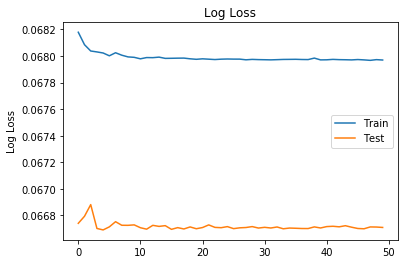

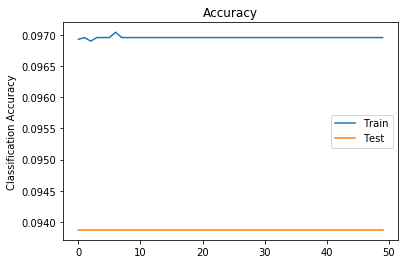

In [98]:
plot_learning_graphs(h.history)

#### Model 2: Fixed-length RNN
Next we build an RNN which will take into account the order of a user's actions to predict the next action.

Model: "RNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
actions (InputLayer)         (None, 10)                0         
_________________________________________________________________
action_embedding (Embedding) (None, 10, 5)             15        
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                17920     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 18,130
Trainable params: 18,130
Non-trainable params: 0
_________________________________________________________________


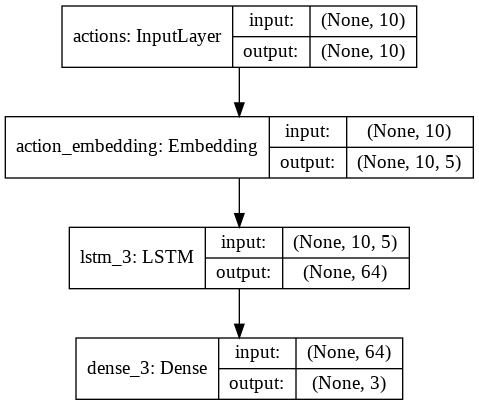

In [6]:
#Create the NN network using the functional API

def rnn_model(input_length, num_units, num_actions):
  # sequence of actions
  A = Input(shape=(input_length,), name="actions") #length of sequence

  #create embedding for actions
  a = Embedding(input_dim=num_actions, output_dim=5, name='action_embedding')(A) # shape 50,64

  #add LSTM Layer
  L = LSTM(num_units,return_sequences=False)(a)

  #add regular NN layer
  predictions = Dense(num_actions, activation='softmax')(L)

  return Model(inputs=A, outputs=predictions, name='RNN_model')

model2 = rnn_model(10, 64, 3)
model2.summary()
plot_model(model2, show_shapes=True, show_layer_names=True)

In [0]:
# create the optimizer
opt2 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

model2.compile(optimizer=opt2, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])

In [104]:
h2 = model2.fit(X_train, y_train, epochs=50, batch_size=128, class_weight={0:0.1, 1: 0.3, 2:0.6}, validation_split=0.1, verbose=1)

Train on 14098 samples, validate on 1567 samples
Epoch 1/50
14098/14098 [==============================] - 8s 568us/step - loss: 0.0725 - acc: 0.9058 - weighted_acc: 0.0942 - val_loss: 0.0592 - val_acc: 0.9024 - val_weighted_acc: 0.0960
Epoch 2/50
14098/14098 [==============================] - 5s 342us/step - loss: 0.0606 - acc: 0.9009 - weighted_acc: 0.0999 - val_loss: 0.0578 - val_acc: 0.8902 - val_weighted_acc: 0.0971
Epoch 3/50
14098/14098 [==============================] - 5s 322us/step - loss: 0.0581 - acc: 0.8988 - weighted_acc: 0.1007 - val_loss: 0.0556 - val_acc: 0.8890 - val_weighted_acc: 0.0970
Epoch 4/50
14098/14098 [==============================] - 4s 316us/step - loss: 0.0578 - acc: 0.8976 - weighted_acc: 0.1006 - val_loss: 0.0553 - val_acc: 0.8934 - val_weighted_acc: 0.0974
Epoch 5/50
14098/14098 [==============================] - 4s 317us/step - loss: 0.0574 - acc: 0.9000 - weighted_acc: 0.1007 - val_loss: 0.0551 - val_acc: 0.8915 - val_weighted_acc: 0.0971
Epoch 6/50


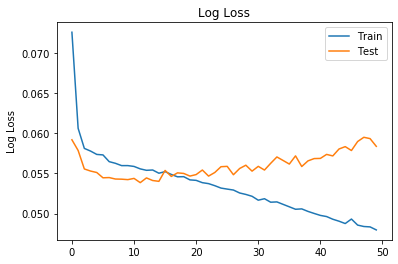

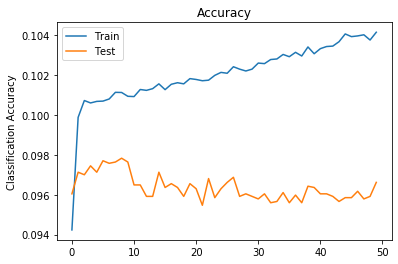

In [105]:
plot_learning_graphs(h2.history)

#### Model 3: Variable length RNN

Here, we use a user session, which can have a variable number of actions, to predict the next action. Popular techniques to create variable length RNNs include padding missing values or bucketing data instances into similar-sized batches. Here, we use the latter where each batch is a size of 1.

Model: "Variable_length_RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
actions (InputLayer)         (None, None)              0         
_________________________________________________________________
action_embedding (Embedding) (None, None, 64)          192       
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 195       
Total params: 33,411
Trainable params: 33,411
Non-trainable params: 0
_________________________________________________________________


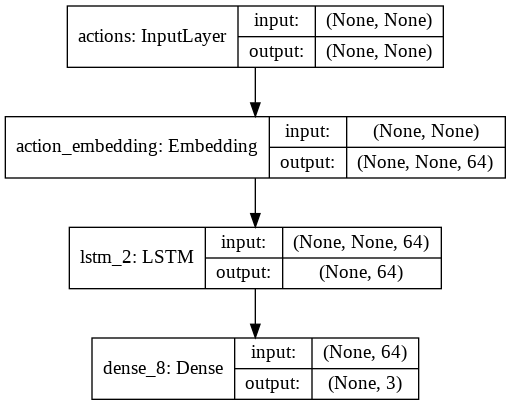

In [61]:

def var_rnn_model(num_units, num_actions):
  # sequence of actions
  A = Input(shape=(None,), name="actions") #input is None as we do not know input length in advance

  #create embedding for actions
  a = Embedding(input_dim=num_actions, output_dim=num_units, name='action_embedding')(A) # do not specify input length
  
  # Create LSTM layer
  # return sequences=False as we only want the last output of the RNN
  L = LSTM(num_units,return_sequences=False)(a)

  predictions = Dense(num_actions, activation='softmax')(L)

  return Model(inputs=A, outputs=predictions, name='Variable_length_RNN')

model3 = var_rnn_model(hidden_size, num_actions)
model3.summary()
plot_model(model3, show_shapes=True, show_layer_names=True)

In [63]:
# create the optimizer
opt3 = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, decay=0.01)

model3.compile(optimizer=opt3, loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])

h3 = model3.fit_generator(MyBatchGenerator(X_sessions_train,y_sessions_train),
                          validation_data=MyBatchGenerator(X_sessions_val,y_sessions_val), 
                          class_weight={0:0.1, 1: 0.3, 2:0.6},
                          epochs=25, 
                          verbose=1)

Epoch 1/25
25600/25600 [==============================] - 144s 6ms/step - loss: 0.4624 - acc: 0.9323 - weighted_acc: 0.0932 - val_loss: 1.0905 - val_acc: 0.9323 - val_weighted_acc: 0.9323
Epoch 2/25
25600/25600 [==============================] - 144s 6ms/step - loss: 0.4624 - acc: 0.9323 - weighted_acc: 0.0932 - val_loss: 1.0905 - val_acc: 0.9323 - val_weighted_acc: 0.9323
Epoch 3/25
25600/25600 [==============================] - 150s 6ms/step - loss: 0.4624 - acc: 0.9323 - weighted_acc: 0.0932 - val_loss: 1.0905 - val_acc: 0.9323 - val_weighted_acc: 0.9323
Epoch 4/25
25600/25600 [==============================] - 143s 6ms/step - loss: 0.4624 - acc: 0.9323 - weighted_acc: 0.0932 - val_loss: 1.0905 - val_acc: 0.9323 - val_weighted_acc: 0.9323
Epoch 5/25
25600/25600 [==============================] - 138s 5ms/step - loss: 0.4624 - acc: 0.9323 - weighted_acc: 0.0932 - val_loss: 1.0905 - val_acc: 0.9323 - val_weighted_acc: 0.9323
Epoch 6/25
25600/25600 [==============================] - 13

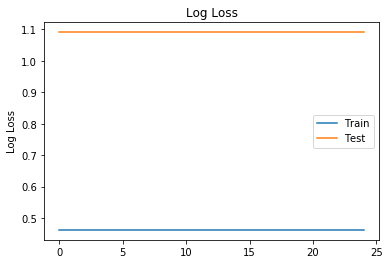

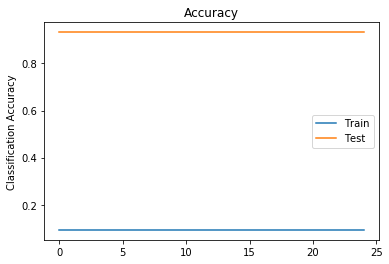

In [64]:
plot_learning_graphs(h3.history)

#### Model 4: Multi-step predictions

This model uses the first n actions to predict the next n actions.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
actions (InputLayer)         (None, 10)                0         
_________________________________________________________________
action_embedding (Embedding) (None, 10, 64)            192       
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dense_9 (Dense)              (None, 10, 3)             195       
_________________________________________________________________
activation_1 (Activation)    (None, 10, 3)             0         
Total params: 33,411
Trainable params: 33,411
Non-trainable params: 0
_________________________________________________________________


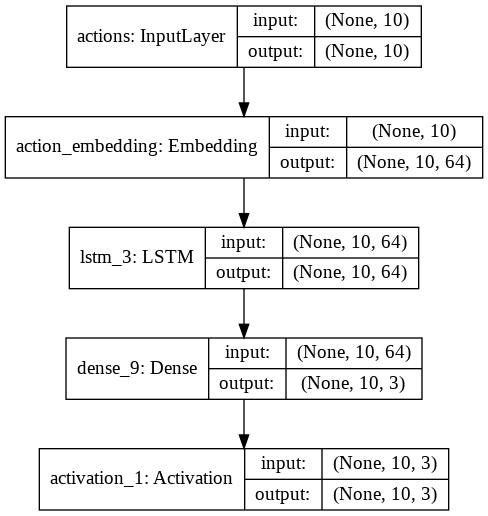

In [67]:
def multistep_rnn_model(input_length, forecast_length, num_units, num_actions):
  # sequence of actions
  A = Input(shape=(input_length,), name="actions") #length of sequence

  #create embedding for actions 
  a = Embedding(input_dim=num_actions, output_dim=num_units, input_length=input_length, name='action_embedding')(A) 

  # return_sequences = True to get the output at each time step
  L = LSTM(num_units,return_sequences=True)(a)

  # Apply a NN for each timestep output
  # predictions = TimeDistributed(Dense(num_actions, activation='softmax'))(L)
  
  predictions = Dense(num_actions)(L)
  predictions = Activation('softmax')(predictions)


  return Model(inputs=A, outputs=predictions)

model4 = multistep_rnn_model(timesteps, timesteps, hidden_size, num_actions)  
model4.summary()

plot_model(model4, show_shapes=True, show_layer_names=True)



In [77]:
opt = Adam(lr=0.1, beta_1=0.9, beta_2=0.999, decay=0.01)

model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
h4 = model4.fit(X_ts_train, y_ts_train, epochs=50, batch_size=128, validation_split=0.1,  verbose=1)

Train on 28224 samples, validate on 3136 samples
Epoch 1/50
28224/28224 [==============================] - 7s 243us/step - loss: 0.3431 - acc: 0.9111 - val_loss: 0.3085 - val_acc: 0.9188
Epoch 2/50
28224/28224 [==============================] - 4s 153us/step - loss: 0.3142 - acc: 0.9166 - val_loss: 0.3094 - val_acc: 0.9188
Epoch 3/50
28224/28224 [==============================] - 5s 164us/step - loss: 0.3147 - acc: 0.9166 - val_loss: 0.3095 - val_acc: 0.9188
Epoch 4/50
28224/28224 [==============================] - 4s 155us/step - loss: 0.3143 - acc: 0.9166 - val_loss: 0.3110 - val_acc: 0.9188
Epoch 5/50
28224/28224 [==============================] - 4s 153us/step - loss: 0.3139 - acc: 0.9166 - val_loss: 0.3077 - val_acc: 0.9188
Epoch 6/50
28224/28224 [==============================] - 5s 162us/step - loss: 0.3135 - acc: 0.9166 - val_loss: 0.3152 - val_acc: 0.9188
Epoch 7/50
28224/28224 [==============================] - 5s 166us/step - loss: 0.3133 - acc: 0.9166 - val_loss: 0.3077 - v

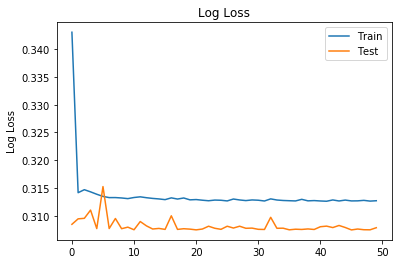

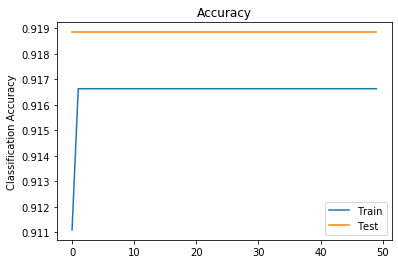

In [78]:
plot_learning_graphs(h4.history)

## Evaluate models

Let's see how our models perform

In [0]:
y_true = np.argmax(y_test,axis=1)

In [0]:
## Model 1 predictions
pred_prob = model.predict(X_test)
y_pred = np.argmax(pred_prob,axis=1)

In [0]:
## Model 2 predictions
pred_prob2 = model2.predict(X_test)
y_pred2 = np.argmax(pred_prob2,axis=1)

In [0]:
## Model 3 predictions
y_true_sessions = np.argmax(y_sessions_test,axis=1)

pred_prob3 = model3.predict_generator(MyBatchGenerator(X_sessions_test,y_sessions_test))
y_pred3 = np.argmax(pred_prob3,axis=1)

In [0]:
## Model 4 predictions
y_ts_test_labels = np.argmax(y_ts_test,axis=2)

pred_prob4 = model4.predict(X_ts_test)
y_pred4 = np.argmax(pred_prob4,axis=2)


Confusion matrix, without normalization
[[3453  126   45]
 [ 140   59    7]
 [  52    9   26]]


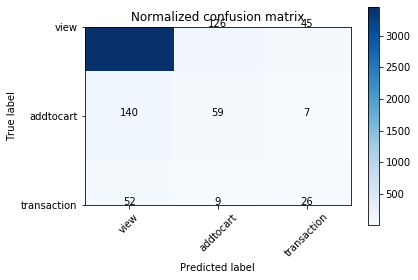

In [100]:
conf=confusion_matrix(y_true,y_pred)
plt.figure()
plot_confusion_matrix(conf, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[3476   71   77]
 [ 138   46   22]
 [  28    8   51]]


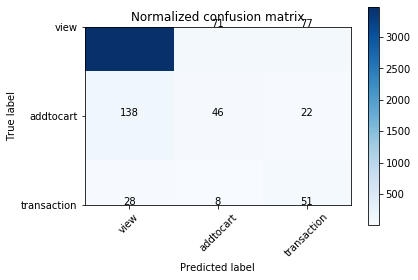

In [107]:
conf2=confusion_matrix(y_true,y_pred2)
plt.figure()
plot_confusion_matrix(conf2, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[7459    0    0]
 [ 318    0    0]
 [ 223    0    0]]


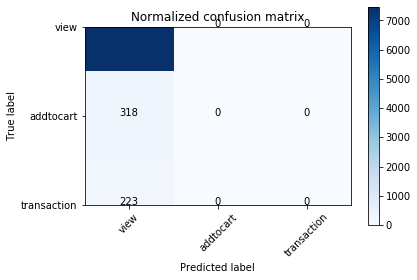

In [66]:
conf3=confusion_matrix(y_true_sessions,y_pred3)
plt.figure()
plot_confusion_matrix(conf3, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

Confusion matrix, without normalization
[[71754     0     0]
 [ 5258     0     0]
 [ 1388     0     0]]


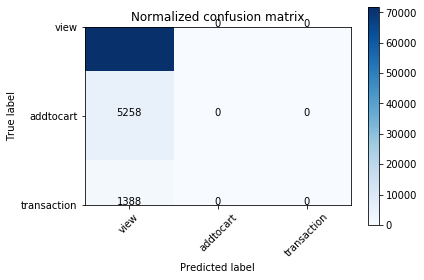

In [80]:
#new shape
num_instances = y_pred4.shape[0]*y_pred4.shape[1]

conf4=confusion_matrix(y_ts_test_labels.reshape((num_instances,)),y_pred4.reshape((num_instances,)))
plt.figure()
plot_confusion_matrix(conf4, classes=action_to_idx.keys(), normalize=False,
                      title='Normalized confusion matrix')
# plt.savefig("cm1.jpg", dpi=900)
plt.show()

In [101]:
print(classification_report(y_true,y_pred,target_names=action_to_idx.keys()))


              precision    recall  f1-score   support

        view       0.95      0.95      0.95      3624
   addtocart       0.30      0.29      0.30       206
 transaction       0.33      0.30      0.32        87

    accuracy                           0.90      3917
   macro avg       0.53      0.51      0.52      3917
weighted avg       0.90      0.90      0.90      3917



In [108]:
print(classification_report(y_true,y_pred2,target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.95      0.96      0.96      3624
   addtocart       0.37      0.22      0.28       206
 transaction       0.34      0.59      0.43        87

    accuracy                           0.91      3917
   macro avg       0.55      0.59      0.56      3917
weighted avg       0.91      0.91      0.91      3917



In [0]:
print(classification_report(y_true_sessions,y_pred3,target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.96      0.97      0.96      7459
   addtocart       0.39      0.06      0.11       318
 transaction       0.39      0.80      0.53       223

    accuracy                           0.93      8000
   macro avg       0.58      0.61      0.53      8000
weighted avg       0.92      0.93      0.92      8000



In [0]:
print(classification_report(y_ts_test_labels.reshape((num_instances,)),y_pred4.reshape((num_instances,)),target_names=action_to_idx.keys()))

              precision    recall  f1-score   support

        view       0.92      1.00      0.96     71754
   addtocart       0.53      0.03      0.06      5258
 transaction       0.00      0.00      0.00      1388

    accuracy                           0.92     78400
   macro avg       0.48      0.34      0.34     78400
weighted avg       0.88      0.92      0.88     78400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For model 4, we also want to evaluate the predictions for each future time step.

In [0]:
def evaluate_predictions(true,predicted):
  scores = [None]*true.shape[1]

  for i in range(true.shape[1]):
    scores[i] = accuracy_score(true[:,i],predicted[:,i])
    print("LAG %d" % i)
    print(classification_report(true[:,i],predicted[:,i]))

  return scores

evaluate_predictions(y_ts_test_labels,y_pred4)

LAG 0
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7180
           1       0.00      0.00      0.00       531
           2       0.00      0.00      0.00       129

    accuracy                           0.92      7840
   macro avg       0.31      0.33      0.32      7840
weighted avg       0.84      0.92      0.88      7840

LAG 1
              precision    recall  f1-score   support

           0       0.91      1.00      0.96      7171
           1       0.00      0.00      0.00       527
           2       0.00      0.00      0.00       142

    accuracy                           0.91      7840
   macro avg       0.30      0.33      0.32      7840
weighted avg       0.84      0.91      0.87      7840

LAG 2
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      7202
           1       0.00      0.00      0.00       492
           2       0.00      0.00      0.00       146

  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[0.9158163265306123,
 0.9146683673469388,
 0.9184948979591837,
 0.9173469387755102,
 0.9165816326530613,
 0.9135204081632653,
 0.9170918367346939,
 0.9125,
 0.9176020408163266,
 0.9135204081632653]

## user2Vec: embedding users

For fun, we can also embed users as well using a similar architecture as model 1. Note that this model would not work for new users as we wouldn't have any history for them. This is known as the cold-start or out of vocabulary problem.

In [23]:
user2vec_model = nn_model(input_length=input_length, num_units=hidden_size, num_actions=num_actions, num_users=num_users)
# user2vec_model.summary()
opt5 = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

user2vec_model.compile(optimizer=opt5, loss='categorical_crossentropy', metrics=['accuracy'])
h5 = user2vec_model.fit([d,X], y, epochs=50, batch_size=128, validation_split=0.1, verbose=0,  class_weight={0:0.1, 1: 0.3, 2:0.6})



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










After training the model, we can get the embeddings from the network and visualize it.

In [0]:
## embeddings for doc2vec model
embeddings = user2vec_model.get_layer(name='user_embedding')
embeddings = embeddings.get_weights()[0]
embeddings = embeddings / np.linalg.norm(embeddings, axis = 1).reshape((-1, 1))
embeddings = np.nan_to_num(embeddings)

### Use tSNE to visualize the embeddings

To visualize each user's vector, we reduce it to two dimensions using tSNE and colour code them with the 51st action

In [0]:
from sklearn.manifold import TSNE


In [0]:
y_labels = np.argmax(y,axis=1)

In [0]:
## Embeddings for doc2vec model
tsne = TSNE(n_components=2, init='pca', random_state=0)
embeddings_reduced = tsne.fit_transform(embeddings)

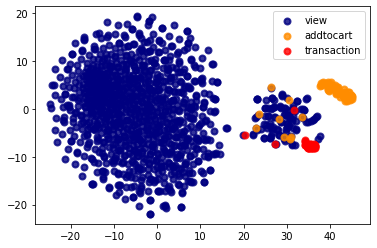

In [29]:
plt.figure()
colors = ['navy', 'darkorange', 'red']
lw = 2
target_names = action_to_idx.keys()

#original points
for color, i, target_name in zip(colors, [0, 1,2], target_names):
    plt.scatter(embeddings_reduced[y_labels == i, 0], embeddings_reduced[y_labels == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.savefig("embedding.png")

We can see above that the NN did a good job of embedding users. The large cluster on the left are users who predominantly view items and a smaller cluster on the right with users who do add the viewed items to their shopping cart and/or checkout.

In [0]:
pickle.dump( visitor_sessions, bz2.BZ2File('visitor_sessions.pkl', 'w') )
pickle.dump( embeddings3, bz2.BZ2File('embeddings3.pkl', 'w') )

## Conclusion

There are many different ways we can build a model to predict user journeys. Here we showed four different ways that only uses previous user actions. Other ideas we can try could be to include additional features into the model, e.g., the characteristics of the items being viewed.

To Dos


*   [ ] visualize sequence of user actions
*   [x] create proper train and test sets
*   [ ] incorporate item features into model
* [x] check LSTM is embedding users correctly
     * [x] create data set by user sessions
* [x] are new users embedded correctly?
    * only 'in vocabulary' users are embedded, to predict new users's actions, you'd have to find their neighbours
* [X] predict next steps
* [ ] add results to slides
* [ ] tidy up and comment code
* [ ] add resources to slides

learn the embeddings, use the embeddings to predict in a separate model

or learn the embeddings in the same model






